Analysis of STED Tom20 Mitos Images
=========

* Old STED data taken 4/09/21 on 2 color STED
* New STED data taken on STEDYCON on various days, listed in data folders below

# Previously done steps:
1. Use Weka segmentation to segment mitochondria from the rest of the cell (using defaults)
2. Masked out the non-mitos to zero values
3. Use Thunderstorm to localize and fit the Tom20 clusters and exported the csv file with the fit data (using defaults)
3. Looked at the FFT along the mitos to see if any particular frequencies pop up-no obvious signal (done with data on old 2 color STED)


# To do now:
* Mitos analysis steps:
    * Size of Tom20 clusters-start with a basic method, later I can try their method if my results don’t make sense
        * Find the average size of the Tom20 clusters in each image (and std) using Thunderstorm csv output
        * Plot the 5 images under the same conditions in a boxcar plot-how is heterogeneity?
        * Plot the different conditions and controls in a boxcar plot, adding together all the images into one dataset
        * maybe do some hypothesis testing of any differences found?
    * Density of Tom20 clusters in mitochondria-their method seems complex, I’m not sure if it’s strictly necessary, so start with a basic method and see if it gets me any useful results
        * calculate total area of mitochondria in an image using the mitos masks
        * calculate the number of spots in the image using Thunderstorm output
        * divide spot number by area for each image
        * compare the results for images under same conditions-find average and std for each condition
        * Hypothesis testing?
    * Normalized variance of fluorescence signal
        * From Mitos paper: “the local variance in the fluorescence intensity of raw STED images was calculated before image segmentation. To this end, the variance was determined in round ROIs with a diameter of seven pixels (∼140 nm). The resulting variance values were assigned to the central pixel of the analyzed ROI. To evaluate the results of the analysis independently from the absolute brightness of the struc- tures, the individual variance values were normalized to the squared average fluorescence intensity of the respective ROI. The variance calculation was repeated using each pixel successively as an ROI center, leading to an image in which each pixel represents the local variance. Finally, the mitochondria-containing fraction of the image was selected by image segmentation using masks as described above. Then, the median of the variance within the mitochondria was determined.”
        * Calculate the fluorescence variance in a round ROI of size ~140 nm for every pixel in the image (except edges of course)
        * Normalize individual variance values for each pixel to the squared average fluorescence intensity of the ROI
        * Then use the mitos mask to segment the image to keep only the pixels in the inside of the mitos
        * Calculate median of the normalized fluorescence values of the pixels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math as m
import os

# STEDYCON: Import the data: **IMPORTANT: folders_path is the path to the data folders.  Change below if you move data.**

One folder named YYMMDD in the folders_path contains all the folders with the different analysis steps
For the raw data from the STEDYCON, the path below without any additional words is the path.
* folders_path + "YYMMDD/Type/YYYY-MM-DD Pierce S "
* then one of the following:
* Decon 3D = deconvolved stack
* Decon = deconvolved middle images
* Stable 3D = stabilized STED images, not deconvolved yet, 3D
* Masks = masks output in different folders for different classifiers
* Mitos = Decon STED image multiplied by the Masks-diff folders for diff classifiers
* Conf 3D = Confocal images, 3D
* TStorm = Thunderstorm output files, in different folders for different classifiers, may also add folders for different TStorm methods/settings

- List different classifiers as folders in Masks, Mitos, TStorm
- TStorm will have classifiers listed as folder.  Need to modify the importing code if I want to try different TStorm settings


In [4]:
#If folders are moved, just change the path below to the new path to the folders with each date
folders_path = "/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/From Dropbox/STED/STED Data/"

In [6]:
#List the first part of the paths for the first set of samples
C1_folder = folders_path + "230802/Control/2023-08-02 Pierce S "
Glu1_folder = folders_path + "230825/Glutamate/2023-08-25 Pierce S "
FAP1_folder = folders_path + "230908/FAP_3hours/2023-09-08 Pierce S "

In [37]:
#List the second part of the paths for the second set of samples
#In this data we took the images for the control sample 2 on two different days
#Combine them to compare samples, may want separate comparisons to compare how microscope day to day changes affect results
C2_folder = folders_path + "231019/Control2/2023-10-19 Pierce S "
C2_folder2 = folders_path + "231117/Control2/2023-11-17 Pierce S "
Glu2_folder = folders_path + "231117/Glu2/2023-11-17 Pierce S "
FAP2_folder = folders_path + "231019/4AP2_3hours/2023-10-19 Pierce S "

### Here list the folders for the final set of data, and classifiers, respectively, then load data

In [11]:
#C_folders = [C1_folder,C2_folder, C2_folder2]
C_folders = [C1_folder,C2_folder, C2_folder2]
C_classifiers = ["IMG0021_Control_Classifier2","IMG0013 classifier", "IMG0013 classifier"]
Glu_folders = [Glu1_folder, Glu2_folder]
Glu_classifiers = ["Glutamate_Image14_Traindata_classifier_2", "IMG0036_classifier"]
FAP_folders = [FAP1_folder, FAP2_folder] #
FAP_classifiers = ["IMG0041_4AP_classifier","IMG0012 4AP classifier"]

In [107]:
# Read in all the data in one loop
#For each classifier/TStorm settings combo, read in .csv file into a Pandas dataframe
#inpub classifier name
def process_folders(folder_paths, classifiers):
    #folder_paths = list of folders with data for this type of sample
    #classifier = name of classifier I want to analyze results from (ie name of folder where masks, mitos and Tstorm data are in
    #TStorm = CONSIDER ADDING FOR DIFFERENT TSTORM ANALYSIS EVETUALLY, BUT FOR NOW DON'T WORRY ABOUT IT
    masks_all = []
    TStormResults_all = []
    tiffs_stable_all = []

    for folder_path, classifier in zip(folder_paths, classifiers):
        #For each folder, read in stable STED data for calculating variance in fluorescence
        folder_path_stable = folder_path + "Stable"
        folder_path_masks = folder_path + "Masks" +"/" + classifier
        folder_path_TStorm = folder_path + "TStorm" +"/" + classifier
        
        filenames_stable = os.listdir(folder_path_stable)
        files_prefix = [filename[:-len("_stable.tif")] for filename in filenames_stable]
        print("List of names of Stable STED raw image files:")
        print(files_prefix)
        filenames_masks = os.listdir(folder_path_masks)
        filenames_TStorm = os.listdir(folder_path_TStorm)
        
        tiffs_stable = []
        masks = []
        TStormResults = []
        for file_prefix in files_prefix:
            print("Working on this file:")
            print(file_prefix)
            if file_prefix != "IMG0032_Glu2_STED": #missing one deconvolved file in Glu2 data, skip it for now.
                tiffs_stable = tiffs_stable + [plt.imread(os.path.join(folder_path_stable, file_prefix + "_stable.tif"))]
                #Find filename in masks directory that matches the file prefix in this loop
                mask_name = [filename for filename in filenames_masks if (filename.startswith(file_prefix) and filename.endswith("_mask.tif"))][0]
                masks = masks + [plt.imread(os.path.join(folder_path_masks, mask_name))]
                #Fine filename in TStorm directory that matches the file prefix in this loop
                TStorm_name = [filename for filename in filenames_TStorm if (filename.startswith(file_prefix) and filename.endswith(".csv"))][0]
                TStormResults = TStormResults + [pd.read_csv(os.path.join(folder_path_TStorm, TStorm_name))]
        tiffs_stable_all = tiffs_stable_all + [tiffs_stable]
        masks_all = masks_all + [masks]
        TStormResults_all = TStormResults_all + [TStormResults]
    return tiffs_stable_all, masks_all, TStormResults_all




                                                         
            
            


In [109]:
C_stable_tiffs, C_masks, C_TStorm = process_folders(C_folders, C_classifiers)

List of names of Stable STED raw image files:
['IMG0012_Control_STED', 'IMG0016_Control_STED', 'IMG0009_Control_STED', 'IMG0015_Control_STED', 'IMG0011_Control_STED', 'IMG0020_Control_STED', 'IMG0017_Control_STED', 'IMG0018_Control_STED', 'IMG0013_Control_STED', 'IMG0021_Control_STED', 'IMG0014_Control_STED', 'IMG0007_Control_STED']
Working on this file:
IMG0012_Control_STED
Working on this file:
IMG0016_Control_STED
Working on this file:
IMG0009_Control_STED
Working on this file:
IMG0015_Control_STED
Working on this file:
IMG0011_Control_STED
Working on this file:
IMG0020_Control_STED
Working on this file:
IMG0017_Control_STED
Working on this file:
IMG0018_Control_STED
Working on this file:
IMG0013_Control_STED
Working on this file:
IMG0021_Control_STED
Working on this file:
IMG0014_Control_STED
Working on this file:
IMG0007_Control_STED
List of names of Stable STED raw image files:
['IMG0011_Control2_STED', 'IMG0018_Control2_STED', 'IMG0014_Control2_STED', 'IMG0016_Control2_STED', 'I

In [111]:
Glu_stable_tiffs, Glu_masks, Glu_TStorm = process_folders(Glu_folders, Glu_classifiers)

List of names of Stable STED raw image files:
['IMG0023_Glutamate_Tom20_STED', 'IMG0031_Glutamate_Tom20_STED', 'IMG0018_Glutamate_Tom20_STED', 'IMG0025_Glutamate_Tom20_STED', 'IMG0016_Glutamate_Tom20_STED', 'IMG0029_Glutamate_Tom20_STED', 'IMG0033_Glutamate_Tom20_STED', 'IMG0021_Glutamate_Tom20_STED', 'IMG0035_Glutamate_Tom20_STED', 'IMG0014_Glutamate_Tom20_STED', 'IMG0027_Glutamate_Tom20_STED', 'IMG0019_Glutamate_Tom20_STED']
Working on this file:
IMG0023_Glutamate_Tom20_STED
Working on this file:
IMG0031_Glutamate_Tom20_STED
Working on this file:
IMG0018_Glutamate_Tom20_STED
Working on this file:
IMG0025_Glutamate_Tom20_STED
Working on this file:
IMG0016_Glutamate_Tom20_STED
Working on this file:
IMG0029_Glutamate_Tom20_STED
Working on this file:
IMG0033_Glutamate_Tom20_STED
Working on this file:
IMG0021_Glutamate_Tom20_STED
Working on this file:
IMG0035_Glutamate_Tom20_STED
Working on this file:
IMG0014_Glutamate_Tom20_STED
Working on this file:
IMG0027_Glutamate_Tom20_STED
Working 

In [113]:
FAP_stable_tiffs, FAP_masks, FAP_TStorm = process_folders(FAP_folders, FAP_classifiers)

List of names of Stable STED raw image files:
['IMG0037_4AP_STED', 'IMG0038_4AP_STED', 'IMG0039_4AP_STED', 'IMG0044_4AP_STED', 'IMG0045_4AP_STED', 'IMG0041_4AP_STED', 'IMG0040_4AP_STED', 'IMG0043_4AP_STED', 'IMG0042_4AP_STED']
Working on this file:
IMG0037_4AP_STED
Working on this file:
IMG0038_4AP_STED
Working on this file:
IMG0039_4AP_STED
Working on this file:
IMG0044_4AP_STED
Working on this file:
IMG0045_4AP_STED
Working on this file:
IMG0041_4AP_STED
Working on this file:
IMG0040_4AP_STED
Working on this file:
IMG0043_4AP_STED
Working on this file:
IMG0042_4AP_STED
List of names of Stable STED raw image files:
['IMG0006_4AP_3_hours_STED', 'IMG0009_4AP_3_hours_STED', 'IMG0020_4AP_3_hours_STED', 'IMG0007_4AP_3_hours_STED', 'IMG0011_4AP_3_hours_STED', 'IMG0014_4AP_3_hours_STED', 'IMG0024_4AP_3_hours_STED', 'IMG0022_4AP_3_hours_STED', 'IMG0004_4AP_3_hours_STED', 'IMG0012_4AP_3_hours_STED', 'IMG0026_4AP_3_hours_STED', 'IMG0005_4AP_3_hours_STED']
Working on this file:
IMG0006_4AP_3_hou

# Analysis 1: Size of Tom20 clusters

## Do Thunderstorm Fit Results FWHM analysis

### Analysis of TStorm Data from each image

In [21]:
### analyze_TStorm
### input: TStorm = a list of pandas DataFrames of the csv output from Thunderstorm on each image taken in a session on one sample
### output: FWHM_mean_all 
def analyze_TStorm(TStorm):
    FWHM_mean_all = []
    FWHM_std_all = []
    FWHM_all = []
    for sample in TStorm:
        num_images = len(sample)
        FWHM_mean = np.zeros(num_images)
        FWHM_std = np.zeros(num_images)
        FWHM = sample[0]['sigma [nm]']
        for i in range(num_images):
            FWHM_mean[i] = sample[i].mean()['sigma [nm]']
            FWHM_std[i] = sample[i].std()['sigma [nm]']
            if i!=0:
                FWHM = pd.concat([FWHM, sample[i]['sigma [nm]']],ignore_index = True)
        print("Mean FWHM:")
        print(FWHM_mean)
        print("STD:")
        print(FWHM_std)
        FWHM_mean_all = FWHM_mean_all + [FWHM_mean]
        FWHM_std_all = FWHM_std_all +[FWHM_std]
        FWHM_all =FWHM_all + [FWHM]
    return FWHM_mean_all, FWHM_std_all, FWHM_all

In [23]:
C_FWHM_mean, C_std, C_FWHM = analyze_TStorm(C_TStorm)

Mean FWHM:
[29.6088962  29.84470411 28.86046103 29.43326368 29.33634058 28.8077879
 30.42569861 28.48762212 29.16737932 30.61371547 29.43242222 30.4772407 ]
STD:
[7.47037332 7.25323417 6.9656431  7.28683059 7.30579559 6.48549633
 7.54031078 6.74639557 7.33929714 8.21380299 7.3343084  7.09453307]
Mean FWHM:
[27.78234662 27.39468659 29.0519103  26.4604254  28.7825595  29.05898741]
STD:
[7.37283854 6.37251385 7.79653669 5.92437278 7.51351533 7.66953177]
Mean FWHM:
[26.67153294 27.26800027 26.21965374 27.31514506 27.1203048  27.24618065
 25.79433578]
STD:
[7.14049282 6.18212046 6.57121831 6.82838037 6.88020234 6.89347565
 6.79914858]


In [25]:
Glu_FWHM_mean, Glu_std, Glu_FWHM = analyze_TStorm(Glu_TStorm)

Mean FWHM:
[25.58797343 27.2884305  29.56245446 27.61950106 27.04553787 29.22417309
 27.6390289  29.69621722 27.62133406 29.46809351 27.5243253  27.28042156]
STD:
[6.543911   6.49021836 7.3693262  6.62820716 6.34099466 7.36279998
 7.37084974 7.27144442 6.1695569  7.56627246 6.44929252 5.90977589]
Mean FWHM:
[29.03107223 26.56777462 25.39217053 27.22273696 28.36911982 20.63664964
 27.27415432 31.47586968 26.40655737 25.86298321 27.1183091 ]
STD:
[ 7.39005398  7.58315055  7.64053702  7.21497846  7.86731337 10.56942533
  7.31511063  8.981306    6.48187983  6.3755626   7.60723024]


In [27]:
FAP_FWHM_mean, FAP_std, FAP_FWHM = analyze_TStorm(FAP_TStorm)

Mean FWHM:
[26.20008626 25.41047892 26.95448138 24.59985018 27.24327285 26.97654086
 28.96451699 26.34570038 26.43685529]
STD:
[6.0978802  6.88345303 6.65071396 6.07529222 6.83796042 6.17264482
 8.43142133 6.63499157 8.91401229]
Mean FWHM:
[26.89751858 30.04613756 30.22163395 28.35652427 27.16266225 28.3613444
 28.17066289 27.03969683 28.26424576 28.53312581 29.52440965 22.67045121]
STD:
[6.84107138 8.37778627 7.90202571 7.10574464 6.30406024 7.47849769
 8.02018241 6.84615935 7.22106576 7.22335023 7.66725807 9.14130691]


### Now Do some TStorm boxplots:

In [ ]:
print(C_FWHM_mean[1])
print(C_FWHM_mean[2])
np.concatenate((C_FWHM_mean[1],C_FWHM_mean[2]))

In [ ]:
#data = [C_FWHM_mean[0], np.concatenate((C_FWHM_mean[1],C_FWHM_mean[2]), Glu_FWHM_mean[0], Glu_FWHM_mean[1], FAP_FWHM_mean[0]]
data = [C_FWHM_mean[0], np.concatenate((C_FWHM_mean[1],C_FWHM_mean[2])), Glu_FWHM_mean[0],Glu_FWHM_mean[1], FAP_FWHM_mean[0], FAP_FWHM_mean[1]]
fig1, ax1 = plt.subplots()
ax1.set_title('Tom20 STEDYCON mean Tstorm FWHM of images')
ax1.set_xlabel('Sample Type')
ax1.boxplot(data, labels=['C1','C2','Glu1','Glu2','4AP1', '4AP2'])
ax1.set_ylabel('Mean FWHM of fits')
plt.show()

Something looks wrong!  The controls are very different in mean FWHM and the FAP's are also very different, and in the opposite direction.  Get the rest of my data before I worry about it, but I mean need to try using the same classifier again?

In [ ]:
data = [np.concatenate((C_FWHM[0],C_FWHM[1],C_FWHM[2])),np.concatenate((Glu_FWHM[0],Glu_FWHM[1])),np.concatenate((FAP_FWHM[0], FAP_FWHM[1]))]
fig1, ax1 = plt.subplots()
ax1.set_title('Comparing conditions, combining all images, samples')
ax1.boxplot(data, labels=['Control','Glu','4AP'])
ax1.set_ylim([0,100])
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
data1 = [result['sigma [nm]'] for result in C_TStorm[0]] 
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('C1 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data1)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
data2 = [result['sigma [nm]'] for result in C_TStorm[1]] + [result['sigma [nm]'] for result in C_TStorm[2]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('C2 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data2)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
C_FWHM_all = data1+data2
fig1, ax1 = plt.subplots()
ax1.set_title('Control Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Images')
ax1.boxplot(C_FWHM_all)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
data = [result['sigma [nm]'] for result in Glu_TStorm[0]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Glu1 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
data2 = [result['sigma [nm]'] for result in Glu_TStorm[1]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Glu2 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
Glu_FWHM_all = data1+data2
fig1, ax1 = plt.subplots()
ax1.set_title('Glu Mitos Tom20 FWHM TStorm ALL')
ax1.set_xlabel('Images')
ax1.boxplot(Glu_FWHM_all)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
data1 = [result['sigma [nm]'] for result in FAP_TStorm[0]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('FAP1 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data1)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
data2 = [result['sigma [nm]'] for result in FAP_TStorm[1]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('FAP2 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data2)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
FAP_FWHM_all=data1+data2
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('FAP Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(FAP_FWHM_all)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

### List the mean and std of the different samples and combines mean/std

In [ ]:
C1_mean = C_FWHM[0].mean()
C1_std = C_FWHM[0].std()
C2_mean = pd.concat([C_FWHM[1],C_FWHM[2]],ignore_index=True).mean()
C2_std = pd.concat([C_FWHM[1],C_FWHM[2]],ignore_index=True).std()
C_mean = pd.concat([C_FWHM[0], C_FWHM[1],C_FWHM[2]],ignore_index = True).mean()
C_std = pd.concat([C_FWHM[0], C_FWHM[1],C_FWHM[2]],ignore_index = True).std()

Glu1_mean = Glu_FWHM[0].mean()
Glu1_std = Glu_FWHM[0].std()
Glu2_mean = Glu_FWHM[1].mean()
Glu2_std = Glu_FWHM[1].mean()
Glu_mean =  pd.concat([Glu_FWHM[0], Glu_FWHM[1]],ignore_index = True).mean()
Glu_std = pd.concat([Glu_FWHM[0], Glu_FWHM[1]],ignore_index = True).std()

FAP1_mean = FAP_FWHM[0].mean()
FAP1_std = FAP_FWHM[0].std()
FAP2_mean = FAP_FWHM[1].mean()
FAP2_std = FAP_FWHM[1].std()
FAP_mean = pd.concat([FAP_FWHM[0], FAP_FWHM[1]],ignore_index = True).mean()
FAP_std = pd.concat([FAP_FWHM[0], FAP_FWHM[1]],ignore_index = True).std()

print('Control1 sigma mean +/- std')
print(f'{C1_mean:.2f}', ' +/- ', f'{C1_std:.2f}')
print('Control2 sigma mean +/- std')
print(f'{C2_mean:.2f}', ' +/- ', f'{C2_std:.2f}')
print('Control sigma mean +/- std')
print(f'{C_mean:.2f}', ' +/- ', f'{C_std:.2f}')
print('Glu1 sigma mean +/- std')
print(f'{Glu1_mean:.2f}', ' +/- ', f'{Glu1_std:.2f}')
print('Glu2 sigma mean +/- std')
print(f'{Glu2_mean:.2f}', ' +/- ', f'{Glu2_std:.2f}')
print('Glu sigma mean +/- std')
print(f'{Glu_mean:.2f}', ' +/- ', f'{Glu_std:.2f}')
print('FAP1 sigma mean +/- std')
print(f'{FAP1_mean:.2f}', ' +/- ', f'{FAP1_std:.2f}')
print('FAP2 sigma mean +/- std')
print(f'{FAP2_mean:.2f}', ' +/- ', f'{FAP2_std:.2f}')
print('FAP sigma mean +/- std')
print(f'{FAP_mean:.2f}', ' +/- ', f'{FAP_std:.2f}')

### Old method folder loading function

In [ ]:
#OLD METHOD: For each classifier, list all the .csv files in the Tstorm folder
folder_paths = C_folders #list with all folders that have control data
file_type = '.csv'


C_subfolders = []
C_TStormResults_all = []

for folder_path in folder_paths:
    folder_path = folder_path+"TStorm"
    files_and_subfolders = os.listdir(folder_path)
    #subfolders should list the different classifiers and/or T
    subfolders = [file for file in files_and_subfolders if os.path.isdir(os.path.join(folder_path, file))]
    print(subfolders)
    C_subfolders = C_subfolders + [subfolders] #list of lists of subfolders for each Control data folder
    C_TStormResults = []
# Use a list comprehension to filter out files that do not match the file type
    for subfolder in subfolders:
        files = os.listdir(os.path.join(folder_path, subfolder))
        #print(files)
        match_files = [file for file in files if file.endswith(file_type)]
# Print the list of matching files
        #print(match_files)
        C_TStorm_Temp = []

        for file in match_files:
            temp = pd.read_csv(os.path.join(folder_path, subfolder, file))
            #print(temp.info())
            C_TStorm_Temp = C_TStorm_Temp + [temp] #list of databases for subfolder
        C_TStormResults = C_TStormResults +[C_TStorm_Temp]  #list of lists of pandas databases with TStorm results for each
    C_TStormResults_all = C_TStormResults_all + [C_TStormResults]

#print(C_TStormResults_all[0][0][5])


                                                         
            
            


## Load Data from OLD 2 Color STED Below

In [137]:
df_4AP_4mM_1 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_1_deconv_10_TStorm1.csv')
df_4AP_4mM_2 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_2_deconv_10_TStorm1.csv')
df_4AP_4mM_3 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_3_deconv_10_TStorm1.csv')
df_4AP_4mM_4 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_4_deconv_10_TStorm1.csv')
df_4AP_4mM_5 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_5_deconv_10_TStorm1.csv')

In [139]:
df_4AP_control_1 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_1_deconv_10_TStorm1.csv')
df_4AP_control_2 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_2_deconv_10_TStorm1.csv')
df_4AP_control_3 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_3_deconv_10_TStorm1.csv')
df_4AP_control_4 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_4_deconv_10_TStorm1.csv')
df_4AP_control_5 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_5_deconv_10_TStorm1.csv')

In [141]:
df_glutamate_0p1uM_1 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_1_deconv_10_TStorm1.csv')
df_glutamate_0p1uM_2 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_2_deconv_10_TStorm1.csv')
df_glutamate_0p1uM_3 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_3_deconv_10_TStorm1.csv')
df_glutamate_0p1uM_4 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_4_deconv_10_TStorm1.csv')
df_glutamate_0p1uM_5 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_5_deconv_10_TStorm1.csv')

In [143]:
df_glutamate_control_1 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_1_deconv_10_TStorm1.csv')
df_glutamate_control_2 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_2_deconv_10_TStorm1.csv')
df_glutamate_control_3 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_3_deconv_10_TStorm1.csv')
df_glutamate_control_4 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_4_deconv_10_TStorm1.csv')
df_glutamate_control_5 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_5_deconv_10_TStorm1.csv')

In [ ]:
df_glutamate_control_1.head()

## OLD STED: Take mean of Thunderstorm Fit values for FWHM
* STEDYCON Analysis: Stop here Jan 18-skip to Density analysis
* For each type of sample, and for each imaging session, and for each analysis type, find the mean and std of the FWHM for each image
* Start with keeping the images separate to see if they look very different, since lots of heterogeneity is seen in the different cells in the paper Ruth sent.  
* Probably need a lot more data to see this with statistical relevance if it's even an effect in our cells though.

###  Starting with Control:

In [ ]:
C_FWHM_mean_all = []
C_FWHM_std_all = []
C_FWHM_all = []
for sample in C_TStormResults_all:
    num_images = len(sample[0])
    C_FWHM_mean = np.zeros(num_images)
    C_FWHM_std = np.zeros(num_images)
    C_FWHM_mean_temp = []
    C_FWHM_std_temp = []
    C_FWHM_temp = []
    for analysis in sample:
        C_FWHM = analysis[0]['sigma [nm]']
        for i in range(num_images):
            C_FWHM_mean[i] = analysis[i].mean()['sigma [nm]']
            C_FWHM_std[i] = analysis[i].std()['sigma [nm]']
            if i!=0:
                C_FWHM.append(analysis[i]['sigma [nm]'],ignore_index = True)
        C_FWHM_mean_temp = C_FWHM_mean_temp + [C_FWHM_mean]
        C_FWHM_std_temp = C_FWHM_std_temp = [C_FWHM_std]
        C_FWHM_temp = C_FWHM_temp +[C_FWHM]
    C_FWHM_mean_all = C_FWHM_mean_all + [C_FWHM_mean_temp]
    C_FWHM_std_all = C_FWHM_std_all +[C_FWHM_std_temp]
    C_FWHM_all = C_FWHM_all + [C_FWHM_temp]

print(C_FWHM_mean_all[0][0])
    

### Glutamate

In [ ]:
Glu_FWHM_mean_all = []
Glu_FWHM_std_all = []
Glu_FWHM_all = []
for sample in Glu_TStormResults_all:
    num_images = len(sample[0])
    Glu_FWHM_mean = np.zeros(num_images)
    Glu_FWHM_std = np.zeros(num_images)
    Glu_FWHM_mean_temp = []
    Glu_FWHM_std_temp = []
    Glu_FWHM_temp = []
    for analysis in sample:
        Glu_FWHM = analysis[0]['sigma [nm]']
        for i in range(num_images):
            Glu_FWHM_mean[i] = analysis[i].mean()['sigma [nm]']
            Glu_FWHM_std[i] = analysis[i].std()['sigma [nm]']
            if i != 0:
                Glu_FWHM.append(analysis[i]['sigma [nm]'],ignore_index = True)
        Glu_FWHM_mean_temp = Glu_FWHM_mean_temp + [Glu_FWHM_mean]
        Glu_FWHM_std_temp = Glu_FWHM_std_temp + [Glu_FWHM_std]
        Glu_FWHM_temp = Glu_FWHM_temp + [Glu_FWHM]
    Glu_FWHM_mean_all = Glu_FWHM_mean_all + [Glu_FWHM_mean_temp]
    Glu_FWHM_std_all = Glu_FWHM_std_all +[Glu_FWHM_std_temp]
    Glu_FWHM_all = Glu_FWHM_all +[Glu_FWHM_temp]

In [ ]:
data = [C_FWHM_mean_all[0][0], Glu_FWHM_mean_all[0][0], Glu_FWHM_mean_all[0][1]]
fig1, ax1 = plt.subplots()
ax1.set_title('Control Tom20 STEDYCON mean FWHM across images in one session/sample')
ax1.set_xlabel('Control')
ax1.boxplot(data, labels=['Control','Glu-analysis1','Glu-analysis2'])
ax1.set_ylabel('Mean FWHM of fits')
plt.show()

In [ ]:
data = [result['sigma [nm]'] for result in C_TStormResults_all[0][0]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot control Mitos Tom20 FWHM TStorm Fit for images')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
data = [result['sigma [nm]'] for result in Glu_TStormResults_all[0][0]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot Glutamate Mitos Tom20 FWHM TStorm Fit for images')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

In [ ]:
data = [result['sigma [nm]'] for result in Glu_TStormResults_all[0][1]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot Glutamate Mitos Tom20 FWHM TStorm Fit for images')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

### Now put all the results from each imaging session together and compare control to Glutamate and 4AP

In [ ]:
C1_mean = C_FWHM_all[0][0].mean()
C1_std = C_FWHM_all[0][0].std()
Glu1_mean = Glu_FWHM_all[0][0].mean()
Glu1_std = Glu_FWHM_all[0][0].std()
Glu2_mean = Glu_FWHM_all[0][1].mean()
Glu2_std = Glu_FWHM_all[0][1].std()

print('Control sigma mean +/- std')
print(f'{C1_mean:.2f}', ' +/- ', f'{C1_std:.2f}')
print('Glutamate analysis 1 sigma mean +/- std')
print(f'{Glu1_mean:.2f}', ' +/- ', f'{Glu1_std:.2f}')
print('Glutamate analysis 2 sigma mean +/- std')
print(f'{Glu2_mean:.2f}', ' +/- ', f'{Glu2_std:.2f}')

Now do a boxplot for the data I currently have analyzed with Thunderstorm, comparing Mask types

In [ ]:
data = [C_FWHM_all[0][0], Glu_FWHM_all[0][0],Glu_FWHM_all[0][1]]
fig1, ax1 = plt.subplots()
ax1.set_title('Comparing conditions and analysis, combining all ROIs')
ax1.boxplot(data, labels=['Control','Glu A1','Glu A2'])
ax1.set_ylim([0,100])
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

## OLD STED data leave here in case I need it for comparison

In [ ]:
df_4AP_4mM_1_sigma_mean = df_4AP_4mM_1.mean()['sigma [nm]']
df_4AP_4mM_1_sigma_std = df_4AP_4mM_1.std()['sigma [nm]']
df_4AP_4mM_2_sigma_mean = df_4AP_4mM_2.mean()['sigma [nm]']
df_4AP_4mM_2_sigma_std = df_4AP_4mM_2.std()['sigma [nm]']
df_4AP_4mM_3_sigma_mean = df_4AP_4mM_3.mean()['sigma [nm]']
df_4AP_4mM_3_sigma_std = df_4AP_4mM_3.std()['sigma [nm]']
df_4AP_4mM_4_sigma_mean = df_4AP_4mM_4.mean()['sigma [nm]']
df_4AP_4mM_4_sigma_std = df_4AP_4mM_4.std()['sigma [nm]']
df_4AP_4mM_5_sigma_mean = df_4AP_4mM_5.mean()['sigma [nm]']
df_4AP_4mM_5_sigma_std = df_4AP_4mM_5.std()['sigma [nm]']
print(f'{df_4AP_4mM_1_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_1_sigma_std:.1f}')
print(f'{df_4AP_4mM_2_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_2_sigma_std:.1f}')
print(f'{df_4AP_4mM_3_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_3_sigma_std:.1f}')
print(f'{df_4AP_4mM_4_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_4_sigma_std:.1f}')
print(f'{df_4AP_4mM_5_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_5_sigma_std:.1f}')

### 4AP Boxplots

In [ ]:
data = [df_4AP_4mM_1['sigma [nm]'], df_4AP_4mM_2['sigma [nm]'],df_4AP_4mM_3['sigma [nm]'],df_4AP_4mM_4['sigma [nm]'],df_4AP_4mM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('4AP 4mM Tom20')
ax1.set_xlabel('ROI #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

### 4AP Controls Mean FWHM of Thunderstorm fits

In [ ]:
df_4AP_control_1_sigma_mean = df_4AP_control_1.mean()['sigma [nm]']
df_4AP_control_1_sigma_std = df_4AP_control_1.std()['sigma [nm]']
df_4AP_control_2_sigma_mean = df_4AP_control_2.mean()['sigma [nm]']
df_4AP_control_2_sigma_std = df_4AP_control_2.std()['sigma [nm]']
df_4AP_control_3_sigma_mean = df_4AP_control_3.mean()['sigma [nm]']
df_4AP_control_3_sigma_std = df_4AP_control_3.std()['sigma [nm]']
df_4AP_control_4_sigma_mean = df_4AP_control_4.mean()['sigma [nm]']
df_4AP_control_4_sigma_std = df_4AP_control_4.std()['sigma [nm]']
df_4AP_control_5_sigma_mean = df_4AP_control_5.mean()['sigma [nm]']
df_4AP_control_5_sigma_std = df_4AP_control_5.std()['sigma [nm]']
print(f'{df_4AP_control_1_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_1_sigma_std:.1f}')
print(f'{df_4AP_control_2_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_2_sigma_std:.1f}')
print(f'{df_4AP_control_3_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_3_sigma_std:.1f}')
print(f'{df_4AP_control_4_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_4_sigma_std:.1f}')
print(f'{df_4AP_control_5_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_5_sigma_std:.1f}')

### 4AP Controls Boxplot

In [ ]:
data = [df_4AP_control_1['sigma [nm]'], df_4AP_control_2['sigma [nm]'],df_4AP_control_3['sigma [nm]'],df_4AP_control_4['sigma [nm]'],df_4AP_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('4AP Control  Tom20')
ax1.set_xlabel('ROI #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

### Glutamate Mean FWHM of Thunderstorm fits

In [ ]:
df_glutamate_0p1uM_1_sigma_mean = df_glutamate_0p1uM_1.mean()['sigma [nm]']
df_glutamate_0p1uM_1_sigma_std = df_glutamate_0p1uM_1.std()['sigma [nm]']
df_glutamate_0p1uM_2_sigma_mean = df_glutamate_0p1uM_2.mean()['sigma [nm]']
df_glutamate_0p1uM_2_sigma_std = df_glutamate_0p1uM_2.std()['sigma [nm]']
df_glutamate_0p1uM_3_sigma_mean = df_glutamate_0p1uM_3.mean()['sigma [nm]']
df_glutamate_0p1uM_3_sigma_std = df_glutamate_0p1uM_3.std()['sigma [nm]']
df_glutamate_0p1uM_4_sigma_mean = df_glutamate_0p1uM_4.mean()['sigma [nm]']
df_glutamate_0p1uM_4_sigma_std = df_glutamate_0p1uM_4.std()['sigma [nm]']
df_glutamate_0p1uM_5_sigma_mean = df_glutamate_0p1uM_5.mean()['sigma [nm]']
df_glutamate_0p1uM_5_sigma_std = df_glutamate_0p1uM_5.std()['sigma [nm]']
print(f'{df_glutamate_0p1uM_1_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_1_sigma_std:.1f}')
print(f'{df_glutamate_0p1uM_2_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_2_sigma_std:.1f}')
print(f'{df_glutamate_0p1uM_3_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_3_sigma_std:.1f}')
print(f'{df_glutamate_0p1uM_4_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_4_sigma_std:.1f}')
print(f'{df_glutamate_0p1uM_5_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_5_sigma_std:.1f}')

### Glutamate Boxplots

In [ ]:
data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Glutamate 0.1 um Tom20')
ax1.set_xlabel('ROI #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

###  Glutmate Controls Mean FWHM of Thunderstorm fits

In [ ]:
df_glutamate_control_1_sigma_mean = df_glutamate_control_1.mean()['sigma [nm]']
df_glutamate_control_1_sigma_std = df_glutamate_control_1.std()['sigma [nm]']
df_glutamate_control_2_sigma_mean = df_glutamate_control_2.mean()['sigma [nm]']
df_glutamate_control_2_sigma_std = df_glutamate_control_2.std()['sigma [nm]']
df_glutamate_control_3_sigma_mean = df_glutamate_control_3.mean()['sigma [nm]']
df_glutamate_control_3_sigma_std = df_glutamate_control_3.std()['sigma [nm]']
df_glutamate_control_4_sigma_mean = df_glutamate_control_4.mean()['sigma [nm]']
df_glutamate_control_4_sigma_std = df_glutamate_control_4.std()['sigma [nm]']
df_glutamate_control_5_sigma_mean = df_glutamate_control_5.mean()['sigma [nm]']
df_glutamate_control_5_sigma_std = df_glutamate_control_5.std()['sigma [nm]']
print(f'{df_glutamate_control_1_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_1_sigma_std:.1f}')
print(f'{df_glutamate_control_2_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_2_sigma_std:.1f}')
print(f'{df_glutamate_control_3_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_3_sigma_std:.1f}')
print(f'{df_glutamate_control_4_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_4_sigma_std:.1f}')
print(f'{df_glutamate_control_5_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_5_sigma_std:.1f}')

### Glutamate Controls Boxplot

In [ ]:
data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Glutamate Control Tom20')
ax1.set_xlabel('ROI #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

## OLD STED: Now combine the data from each condition.

In [ ]:
df_4AP_4mM = df_4AP_4mM_1.append(df_4AP_4mM_2, sort=False, ignore_index=True)
df_4AP_4mM = df_4AP_4mM.append(df_4AP_4mM_3, sort=False, ignore_index=True)
df_4AP_4mM = df_4AP_4mM.append(df_4AP_4mM_4, sort=False, ignore_index=True)
df_4AP_4mM = df_4AP_4mM.append(df_4AP_4mM_5, sort=False, ignore_index=True)
df_4AP_4mM_sigma_mean = df_4AP_4mM.mean()['sigma [nm]']
df_4AP_4mM_sigma_std = df_4AP_4mM.std()['sigma [nm]']
print('4AP 4mM sigma mean +/- std')
print(f'{df_4AP_4mM_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_sigma_std:.1f}')

In [ ]:
df_4AP_control = df_4AP_control_1.append(df_4AP_control_2, sort=False, ignore_index=True)
df_4AP_control = df_4AP_control.append(df_4AP_control_3, sort=False, ignore_index=True)
df_4AP_control = df_4AP_control.append(df_4AP_control_4, sort=False, ignore_index=True)
df_4AP_control = df_4AP_control.append(df_4AP_control_5, sort=False, ignore_index=True)
df_4AP_control_sigma_mean = df_4AP_control.mean()['sigma [nm]']
df_4AP_control_sigma_std = df_4AP_control.std()['sigma [nm]']
print('4AP Control sigma mean +/- std')
print(f'{df_4AP_control_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_sigma_std:.1f}')

In [ ]:
df_glutamate_0p1uM = df_glutamate_0p1uM_1.append(df_glutamate_0p1uM_2, sort=False, ignore_index=True)
df_glutamate_0p1uM = df_glutamate_0p1uM.append(df_glutamate_0p1uM_3, sort=False, ignore_index=True)
df_glutamate_0p1uM = df_glutamate_0p1uM.append(df_glutamate_0p1uM_4, sort=False, ignore_index=True)
df_glutamate_0p1uM = df_glutamate_0p1uM.append(df_glutamate_0p1uM_5, sort=False, ignore_index=True)
df_glutamate_0p1uM_sigma_mean = df_glutamate_0p1uM.mean()['sigma [nm]']
df_glutamate_0p1uM_sigma_std = df_glutamate_0p1uM.std()['sigma [nm]']
print('Glutamate 0.1 uM sigma mean +/- std')
print(f'{df_glutamate_0p1uM_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_sigma_std:.1f}')

In [ ]:
df_glutamate_control = df_glutamate_control_1.append(df_glutamate_control_2, sort=False, ignore_index=True)
df_glutamate_control = df_glutamate_control.append(df_glutamate_control_3, sort=False, ignore_index=True)
df_glutamate_control = df_glutamate_control.append(df_glutamate_control_4, sort=False, ignore_index=True)
df_glutamate_control = df_glutamate_control.append(df_glutamate_control_5, sort=False, ignore_index=True)
df_glutamate_control_sigma_mean = df_glutamate_control.mean()['sigma [nm]']
df_glutamate_control_sigma_std = df_glutamate_control.std()['sigma [nm]']
print('Glutamate Control sigma mean +/- std')
print(f'{df_glutamate_control_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_sigma_std:.1f}')

In [ ]:
data = [df_4AP_4mM['sigma [nm]'], df_4AP_control['sigma [nm]'],df_glutamate_0p1uM['sigma [nm]'],df_glutamate_control['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Comparing conditions, combining all ROIs')
ax1.boxplot(data, labels=['4AP','4AP control','glutamate','glutamate control'])
ax1.set_ylim([0,100])
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

# Analysis 2: Tom20 Spot Density

## STEDYCON DATA: Find Spot density using Mitos masks
* Find the total area of mitos in spots per pixel of mitos.
* Scale to spots/micron^2 by dividing by 1 pixel/(.020 um)^2
* Size of the pixels in STEDYCON data is 25 nm
* Take total length of dataframe with TStorm output and divide by total number of pixels in mask, divided by pixel size squared

In [115]:
def calc_density(TStorms,Masks):
    density_all = []
    for sesh_TStorms, sesh_Masks in zip(TStorms, Masks):
            num_images = len(sesh_TStorms)
            print('num images in this session: ', num_images)
            density = np.zeros(num_images)
            for i in range(num_images):
                density[i] = (sesh_TStorms[i].shape[0]/np.sum(sesh_Masks[i]/255))/(0.025**2)
            print('density = ', density)
            density_all = density_all + [density]
    return density_all
C_density = calc_density(C_TStorm, C_masks)
Glu_density = calc_density(Glu_TStorm,Glu_masks)
FAP_density = calc_density(FAP_TStorm,FAP_masks)

print(C_density[0][0])
print(Glu_density[0][0])
print(FAP_density[0][0])

num images in this session:  12
density =  [12.61475192 14.87772452 13.84355765 13.97267519 14.41514386 13.63669846
 14.55706277 11.07160634 15.00148845 12.53581037 13.18801675 13.14264271]
num images in this session:  6
density =  [20.87064993 22.07655199 18.22950837 20.91280404 21.55600107 20.10305708]
num images in this session:  7
density =  [18.15522307 18.06039386 16.92465578 17.39481792 16.28904217 17.42769213
 16.3540923 ]
num images in this session:  12
density =  [14.66773359 13.67560103 14.67696394 13.93823652 17.04678681 14.1803701
 15.74599037 13.21711029 14.29898354 18.17685812 13.09301444 14.15763527]
num images in this session:  11
density =  [26.31638925 21.04063596 23.12873566 19.80716901 24.21720902 23.72788138
 21.25240017 35.24344495 18.02315976 18.48532054 16.84165668]
num images in this session:  9
density =  [26.80726493 21.93335533 22.75928858 24.40342283 30.37585312 23.15572701
 21.99896344 31.52215531 21.87701209]
num images in this session:  12
density =  [1

### SAVE: Density results into Results Folder for Statistics Analysis by Emily

In [119]:
np.savetxt(C1_folder + 'Results/C1_Density.csv', np.array(C_density[0]), delimiter=',')
np.savetxt(C2_folder + 'Results/C2_Density1', np.array(C_density[1]), delimiter=',')
np.savetxt(C2_folder2 + 'Results/C2_Density2', np.array(C_density[2]),delimiter=',')
np.savetxt(C2_folder2 + 'Results/C2_Density', np.concatenate((C_density[1],C_density[2])), delimiter=',')
np.savetxt(Glu1_folder + 'Results/Glu1_Density.csv', np.array(Glu_density[0]), delimiter=',')
np.savetxt(Glu2_folder + 'Results/Glu2_Density.csv', np.array(Glu_density[1]), delimiter=',')
np.savetxt(FAP1_folder + 'Results/FAP1_Density.csv', np.array(FAP_density[0]), delimiter=',')
np.savetxt(FAP2_folder + 'Results/FAP2_Density.csv', np.array(FAP_density[1]), delimiter=',')

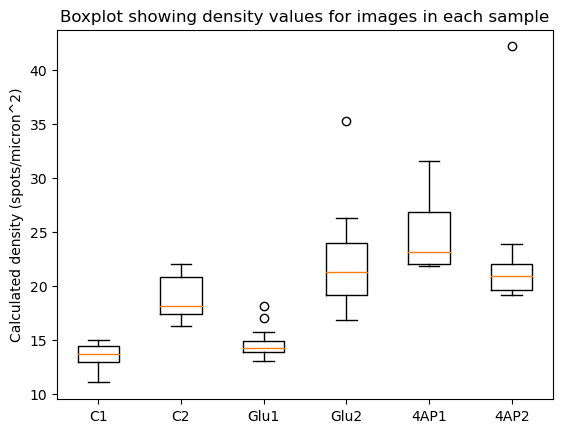

In [121]:
data = [C_density[0]] + [np.concatenate((C_density[1],C_density[2]))] + Glu_density + FAP_density

fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot showing density values for images in each sample')
ax1.boxplot(data, labels=['C1','C2','Glu1','Glu2','4AP1','4AP2'])
#ax1.set_ylim([0,100])
ax1.set_ylabel('Calculated density (spots/micron^2)')
plt.show()

# OLD STED DATA: Now find the spot density by using the Mitos masks

In [127]:
mask_4AP_4mM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_1_deconv_10_ClassifierResult.tif')/255
mask_4AP_4mM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_2_deconv_10_ClassifierResult.tif')/255
mask_4AP_4mM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_3_deconv_10_ClassifierResult.tif')/255
mask_4AP_4mM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_4_deconv_10_ClassifierResult.tif')/255
mask_4AP_4mM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_5_deconv_10_ClassifierResult.tif')/255

In [129]:
mask_4AP_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_1_deconv_10_ClassifierResult.tif')/255
mask_4AP_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_2_deconv_10_ClassifierResult.tif')/255
mask_4AP_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_3_deconv_10_ClassifierResult.tif')/255
mask_4AP_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_4_deconv_10_ClassifierResult.tif')/255
mask_4AP_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_5_deconv_10_ClassifierResult.tif')/255

In [131]:
mask_glutamate_0p1uM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_1_deconv_10_ClassifierResult.tif')/255
mask_glutamate_0p1uM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_2_deconv_10_ClassifierResult.tif')/255
mask_glutamate_0p1uM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_3_deconv_10_ClassifierResult.tif')/255
mask_glutamate_0p1uM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_4_deconv_10_ClassifierResult.tif')/255
mask_glutamate_0p1uM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_5_deconv_10_ClassifierResult.tif')/255

In [133]:
mask_glutamate_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_1_deconv_10_ClassifierResult.tif')/255
mask_glutamate_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_2_deconv_10_ClassifierResult.tif')/255
mask_glutamate_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_3_deconv_10_ClassifierResult.tif')/255
mask_glutamate_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_4_deconv_10_ClassifierResult.tif')/255
mask_glutamate_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_5_deconv_10_ClassifierResult.tif')/255

### Find the total area of mitos in spots per pixel of mitos.
Scale to spots/micron^2 by dividing by 1 pixel/(.020 um)^2

In [145]:
dens_4AP_4mM_1 = (df_4AP_4mM_1.shape[0]/np.sum(mask_4AP_4mM_1))/(0.02**2)
dens_4AP_4mM_2 = (df_4AP_4mM_2.shape[0]/np.sum(mask_4AP_4mM_2))/(0.02**2)
dens_4AP_4mM_3 = (df_4AP_4mM_3.shape[0]/np.sum(mask_4AP_4mM_3))/(0.02**2)
dens_4AP_4mM_4 = (df_4AP_4mM_4.shape[0]/np.sum(mask_4AP_4mM_4))/(0.02**2)
dens_4AP_4mM_5 = (df_4AP_4mM_5.shape[0]/np.sum(mask_4AP_4mM_5))/(0.02**2)
STED1_density_4AP = np.array([dens_4AP_4mM_1,dens_4AP_4mM_2, dens_4AP_4mM_3, dens_4AP_4mM_4, dens_4AP_4mM_5])
print((df_4AP_4mM_1.shape[0]/np.sum(mask_4AP_4mM_1) + df_4AP_4mM_2.shape[0]/np.sum(mask_4AP_4mM_2)+df_4AP_4mM_3.shape[0]/np.sum(mask_4AP_4mM_3)+df_4AP_4mM_4.shape[0]/np.sum(mask_4AP_4mM_4)+df_4AP_4mM_5.shape[0]/np.sum(mask_4AP_4mM_5))/5)

0.020548276534144237


In [147]:
FAP_density_all = FAP_density + [STED1_density_4AP]

In [149]:
print(dens_4AP_4mM_1)
print(dens_4AP_4mM_2)
print(dens_4AP_4mM_3)
print(dens_4AP_4mM_4)
print(dens_4AP_4mM_5)
print((dens_4AP_4mM_1+dens_4AP_4mM_2+dens_4AP_4mM_3+dens_4AP_4mM_4+dens_4AP_4mM_5)/5)

51.40522498855801
47.148409733670086
49.71953085160632
56.24963355287588
52.33065755009265
51.3706913353606


In [151]:
dens_4AP_control_1 = (df_4AP_control_1.shape[0]/np.sum(mask_4AP_control_1))/(0.02**2)
dens_4AP_control_2 = (df_4AP_control_2.shape[0]/np.sum(mask_4AP_control_2))/(0.02**2)
dens_4AP_control_3 = (df_4AP_control_3.shape[0]/np.sum(mask_4AP_control_3))/(0.02**2)
dens_4AP_control_4 = (df_4AP_control_4.shape[0]/np.sum(mask_4AP_control_4))/(0.02**2)
dens_4AP_control_5 = (df_4AP_control_5.shape[0]/np.sum(mask_4AP_control_5))/(0.02**2)
STED1_density_4AP_control = np.array([dens_4AP_control_1,dens_4AP_control_2, dens_4AP_control_3, dens_4AP_control_4, dens_4AP_control_5])

In [153]:
C_density_all = C_density + [STED1_density_4AP_control]

In [155]:
print(dens_4AP_control_1)
print(dens_4AP_control_2)
print(dens_4AP_control_3)
print(dens_4AP_control_4)
print(dens_4AP_control_5)
print((dens_4AP_control_1+dens_4AP_control_2+dens_4AP_control_3+dens_4AP_control_4+dens_4AP_control_5)/5)

61.53059697770684
71.35302876386356
64.76325687735084
50.572447306263065
69.45488178507428
63.53484234205172


In [157]:
dens_glutamate_0p1uM_1 = (df_glutamate_0p1uM_1.shape[0]/np.sum(mask_glutamate_0p1uM_1))/(0.02**2)
dens_glutamate_0p1uM_2 = (df_glutamate_0p1uM_2.shape[0]/np.sum(mask_glutamate_0p1uM_2))/(0.02**2)
dens_glutamate_0p1uM_3 = (df_glutamate_0p1uM_3.shape[0]/np.sum(mask_glutamate_0p1uM_3))/(0.02**2)
dens_glutamate_0p1uM_4 = (df_glutamate_0p1uM_4.shape[0]/np.sum(mask_glutamate_0p1uM_4))/(0.02**2)
dens_glutamate_0p1uM_5 = (df_glutamate_0p1uM_5.shape[0]/np.sum(mask_glutamate_0p1uM_5))/(0.02**2)
STED1_density_glu = np.array([dens_glutamate_0p1uM_1,dens_glutamate_0p1uM_2, dens_glutamate_0p1uM_3,dens_glutamate_0p1uM_4,dens_glutamate_0p1uM_5])

In [159]:
Glu_density_all = Glu_density + [STED1_density_glu]

In [ ]:
print(dens_glutamate_0p1uM_1)
print(dens_glutamate_0p1uM_2)
print(dens_glutamate_0p1uM_3)
print(dens_glutamate_0p1uM_4)
print(dens_glutamate_0p1uM_5)
print((dens_glutamate_0p1uM_1+dens_glutamate_0p1uM_2+dens_glutamate_0p1uM_3+dens_glutamate_0p1uM_4+dens_glutamate_0p1uM_5)/5)

In [161]:
dens_glutamate_control_1 = (df_glutamate_control_1.shape[0]/np.sum(mask_glutamate_control_1))/(0.02**2)
dens_glutamate_control_2 = (df_glutamate_control_2.shape[0]/np.sum(mask_glutamate_control_2))/(0.02**2)
dens_glutamate_control_3 = (df_glutamate_control_3.shape[0]/np.sum(mask_glutamate_control_3))/(0.02**2)
dens_glutamate_control_4 = (df_glutamate_control_4.shape[0]/np.sum(mask_glutamate_control_4))/(0.02**2)
dens_glutamate_control_5 = (df_glutamate_control_5.shape[0]/np.sum(mask_glutamate_control_5))/(0.02**2)
STED1_density_glu_control = np.array([dens_glutamate_control_1,dens_glutamate_control_3, dens_glutamate_control_3, dens_glutamate_control_4,dens_glutamate_control_5])

In [163]:
C_density_all = C_density_all + [STED1_density_glu_control]

In [ ]:
print(dens_glutamate_control_1)
print(dens_glutamate_control_2)
print(dens_glutamate_control_3)
print(dens_glutamate_control_4)
print(dens_glutamate_control_5)
print((dens_glutamate_control_1+dens_glutamate_control_2+dens_glutamate_control_3+dens_glutamate_control_4+dens_glutamate_control_5)/5)

## Now plot STED1 density and STEDYCON density on same axes

In [ ]:
C_density_all[4]

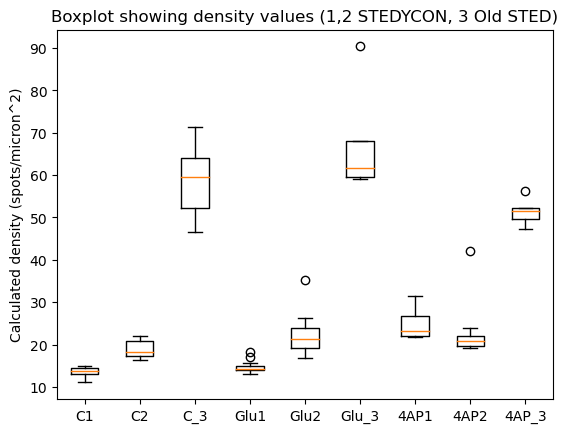

In [165]:
data = [C_density_all[0]] + [np.concatenate((C_density_all[1],C_density_all[2]))]+[np.concatenate((C_density_all[3],C_density_all[4]))]+ Glu_density_all + FAP_density_all

fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot showing density values (1,2 STEDYCON, 3 Old STED)')
ax1.boxplot(data, labels=['C1','C2','C_3','Glu1','Glu2', 'Glu_3','4AP1','4AP2','4AP_3'])
#ax1.set_ylim([0,100])
ax1.set_ylabel('Calculated density (spots/micron^2)')
plt.show()

In [ ]:
print(len(FAP_density_all))

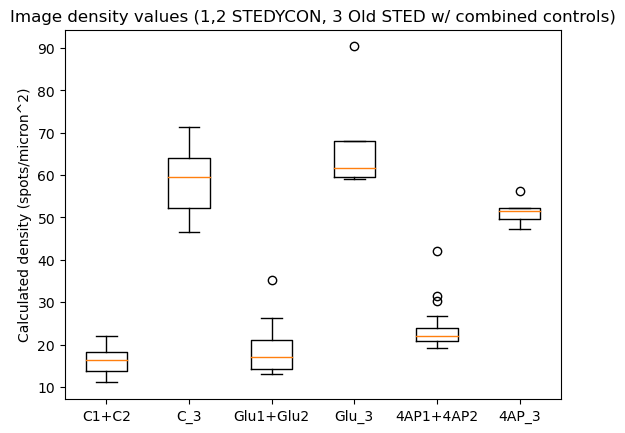

In [167]:
data = [np.concatenate((C_density_all[0],C_density_all[1],C_density_all[2]))]+[np.concatenate((C_density_all[3],C_density_all[4]))]+ [np.concatenate((Glu_density_all[0],Glu_density_all[1]))]+[Glu_density_all[2]] + [np.concatenate((FAP_density_all[0],FAP_density_all[1]))]+[FAP_density_all[2]]

fig1, ax1 = plt.subplots()
ax1.set_title('Image density values (1,2 STEDYCON, 3 Old STED w/ combined controls)')
ax1.boxplot(data, labels=['C1+C2','C_3','Glu1+Glu2','Glu_3','4AP1+4AP2','4AP_3'])
#ax1.set_ylim([0,100])
ax1.set_ylabel('Calculated density (spots/micron^2)')
plt.show()

# Analysis 3: Mitos variance of fluorescence

From the Tom20 STED paper:
"Variance Analysis. To exclude an influence of the image segmentation process on the determined variance values, the local variance in the fluorescence intensity of raw STED images was calculated before image segmentation. To this end, the variance was determined in round ROIs with a diameter of seven pixels (∼140 nm). The resulting variance values were assigned to the central pixel of the analyzed ROI. To evaluate the results of the analysis independently from the absolute brightness of the structures,
the individual variancevalues werenormalized to the
squared average fluorescence intensity of the respective ROI. The variance calculation was repeated using each pixel successively as an ROI center, leading to an image in which each pixel represents the local variance. Finally, the mitochondria-containing fraction of the image was selected by image segmentation using masks as described above. Then, the median of the variance within the mitochondria was determined."

## Loading OLD STED Data

In [ ]:
raw_4AP_4mM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_1_raw.tif')
raw_4AP_4mM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_2_raw.tif')
raw_4AP_4mM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_3_raw.tif')
raw_4AP_4mM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_4_raw.tif')
raw_4AP_4mM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_5_raw.tif')

In [ ]:
raw_4AP_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_1_raw.tif')
raw_4AP_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_2_raw.tif')
raw_4AP_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_3_raw.tif')
raw_4AP_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_4_raw.tif')
raw_4AP_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_5_raw.tif')

In [ ]:
raw_glutamate_0p1uM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_1_raw.tif')
raw_glutamate_0p1uM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_2_raw.tif')
raw_glutamate_0p1uM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_3_raw.tif')
raw_glutamate_0p1uM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_4_raw.tif')
raw_glutamate_0p1uM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_5_raw.tif')

In [ ]:
raw_glutamate_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_1_raw.tif')
raw_glutamate_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_2_raw.tif')
raw_glutamate_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_3_raw.tif')
raw_glutamate_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_4_raw.tif')
raw_glutamate_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_5_raw.tif')

In [ ]:
plt.imshow(raw_4AP_4mM_1)


## Function to calculate normalized fluorescence variance image:
* At each point that is far enough from an edge
    * select out the ROI values with pixel centers <= r+1/2 from (i,j)
    * Take the variance
    * put at the center pixel value for the new var matrix.

In [169]:
# r must be positive, in units of pixel size
### fluo_var_image generates an image of the variance of the fluorescence for an image with an ROI half radius, rounded down, of r.
def fluo_var_image(image,r):
    (xmax,ymax)=image.shape
    var_image = np.zeros((xmax,ymax))
    select_mat = np.zeros((2*r+1,2*r+1))
    for p in range(2*r+1):
        for q in range(2*r+1):
            if (m.sqrt((p-(r))**2 + (q-(r))**2) <= (r+0.5)):
                select_mat[p,q] = 1
            else:
                select_mat[p,q] = np.nan
    for i in range(xmax):
        for j in range(ymax):
            if ((i-r) > 0 and (i+r) < (xmax-1)) and ((j-r) > 0 and (j+r) < (ymax-1)):
               # roi = np.multiply(image[i-r:i+r+1,j-r:j+r+1],select_mat)
                roi = np.multiply(image[i-r:i+r+1,j-r:j+r+1],select_mat)
                var_image[i,j] = np.nanvar(roi)/(np.nanmean(roi)**2)
    return var_image

## Testing the function:
Check if it's all zeros or all ones that I get what I expect (zero and undefined)

In [ ]:
test_ones = np.ones((128,128))
test_zeros = np.zeros((128,128))
print(fluo_var_image(test_ones,3))
print(fluo_var_image(test_zeros,3))

### Test on Random image

In [ ]:
a = np.random.rand(10000)
a=50 * a
image =np.reshape(a,(100,100))
test = fluo_var_image(image, 3)

The Values I'm getting are all below one and most are closer to 0 than 1, as expected from a random number distribution on \[0,1]

In [ ]:
fig, ax = plt.subplots(figsize=(16,16), nrows=1,ncols=2)
plt.tight_layout() 
#Gaussian Excitation

im1 = ax[0].imshow(test,cmap='jet'); ax[0].set_title('Random Data test')
plt.colorbar(im1)
plt.show()

### Normalized variance calculation on the images.
* First calcualte the normalized fluorescence image
* Then use the mito mask to select only the normalized fluorescence values inside the mitos
* Then calculate the median normalized fluorescence in each image and for each condition find the total median.

## STEDYCON Data Analysis of Normalized Variance of Fluorescence
* In a loop for each sample, for each image
    * Calculate norm variance of fluor image from raw image
    * Multiply norm variance of fluor image by mask/255
    * Get rid of values that are 0
    * Save results in a csv file for Emily

In [172]:
def calc_save_normfluor(Stable,Masks,folders):
    for sesh_Stable, sesh_Masks, sesh_folder in zip(Stable, Masks, folders):
            num_images = len(sesh_Stable)
            print('num images in this session: ', num_images)
            
            for i in range(num_images):
                temp1 = fluo_var_image(sesh_Stable[i],3)
                temp2 = np.multiply(sesh_Masks[i],temp1)/255
                temp3 = temp2[temp2!=0]
                np.savetxt(sesh_folder + "Results/NormFluor" + str(i) + ".csv", temp3, delimiter=',')

                
calc_save_normfluor(C_stable_tiffs,C_masks,C_folders)
calc_save_normfluor(Glu_stable_tiffs,Glu_masks,Glu_folders)
calc_save_normfluor(FAP_stable_tiffs,FAP_masks,FAP_folders)

num images in this session:  12


/var/folders/_n/8p0r8jdj1zl2x6wdg499kh000000gn/T/ipykernel_78214/730883764.py:18: RuntimeWarning: invalid value encountered in scalar divide
  var_image[i,j] = np.nanvar(roi)/(np.nanmean(roi)**2)


num images in this session:  6
num images in this session:  7


NameError: name 'Glu_Stable_tiffs' is not defined

## OLD STED Data Normalized Variance of Fluorescence:


### 4AP Normalized Variance of Fluorescence Calculation


In [ ]:
normvar_4AP_4mM_1 = fluo_var_image(raw_4AP_4mM_1,3)

In [ ]:
normvar_4AP_4mM_2 = fluo_var_image(raw_4AP_4mM_2,3)

In [ ]:
normvar_4AP_4mM_3 = fluo_var_image(raw_4AP_4mM_3,3)

In [ ]:
normvar_4AP_4mM_4 = fluo_var_image(raw_4AP_4mM_4,3)

In [ ]:
normvar_4AP_4mM_5 = fluo_var_image(raw_4AP_4mM_5,3)

In [ ]:
mask_4AP_4mM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_1_deconv_10_ClassifierResult.tif')
mask_4AP_4mM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_2_deconv_10_ClassifierResult.tif')
mask_4AP_4mM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_3_deconv_10_ClassifierResult.tif')
mask_4AP_4mM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_4_deconv_10_ClassifierResult.tif')
mask_4AP_4mM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_5_deconv_10_ClassifierResult.tif')

Multiply normalized variance image by mask, then divide by 255 since it's 8-bit.

In [ ]:
nvarr_m_4AP_4mM_1 = np.multiply(mask_4AP_4mM_1,normvar_4AP_4mM_1)/255 #m=masked, f=final version with 0's removed
nvarr_f_4AP_4mM_1 = nvarr_m_4AP_4mM_1[nvarr_m_4AP_4mM_1 != 0]
nvarr_m_4AP_4mM_2 = np.multiply(mask_4AP_4mM_2, normvar_4AP_4mM_2)/255
nvarr_f_4AP_4mM_2 = nvarr_m_4AP_4mM_2[nvarr_m_4AP_4mM_2 != 0]
nvarr_m_4AP_4mM_3 = np.multiply(mask_4AP_4mM_3,normvar_4AP_4mM_3)/255
nvarr_f_4AP_4mM_3 = nvarr_m_4AP_4mM_3[nvarr_m_4AP_4mM_3 != 0]
nvarr_m_4AP_4mM_4 = np.multiply(mask_4AP_4mM_4,normvar_4AP_4mM_4)/255
nvarr_f_4AP_4mM_4 = nvarr_m_4AP_4mM_4[nvarr_m_4AP_4mM_4 != 0]
nvarr_m_4AP_4mM_5 = np.multiply(mask_4AP_4mM_5,normvar_4AP_4mM_5)/255
nvarr_f_4AP_4mM_5 = nvarr_m_4AP_4mM_5[nvarr_m_4AP_4mM_5 != 0]

In [ ]:
#nvarr_f_4AP_4mM_1.shape
x = np.arange(0,267079, 1)
plt.hist(nvarr_f_4AP_4mM_1)

In [ ]:
#data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1,ncols=5)
ax1[0].set_title('4AP 4mM Tom20')
ax1[0].set_xlabel('1')
ax1[0].boxplot(nvarr_f_4AP_4mM_1)
ax1[0].set_ylabel('Normalized Fluorescence')
ax1[1].set_xlabel('2')
ax1[1].boxplot(nvarr_f_4AP_4mM_2)
ax1[2].set_xlabel('3')
ax1[2].boxplot(nvarr_f_4AP_4mM_3)
ax1[3].set_xlabel('4')
ax1[3].boxplot(nvarr_f_4AP_4mM_4)
ax1[4].set_xlabel('5')
ax1[4].boxplot(nvarr_f_4AP_4mM_5)
plt.show()

In [ ]:
print(np.median(nvarr_f_4AP_4mM_1))
print(np.median(nvarr_f_4AP_4mM_2))
print(np.median(nvarr_f_4AP_4mM_3))
print(np.median(nvarr_f_4AP_4mM_4))
print(np.median(nvarr_f_4AP_4mM_5))

In [ ]:
print(np.std(nvarr_f_4AP_4mM_1))
print(np.std(nvarr_f_4AP_4mM_2))
print(np.std(nvarr_f_4AP_4mM_3))
print(np.std(nvarr_f_4AP_4mM_4))
print(np.std(nvarr_f_4AP_4mM_5))

Wait a second, the standard deviation is higher than the median for some of these images's normalized fluorescence values!  Weird.  It's for the images where there are values really far from the median...might want to throw away some outliers but how to decide?

### 4AP Control Normalized Variance of Fluorescence Calculation

In [ ]:
mask_4AP_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_1_deconv_10_ClassifierResult.tif')
mask_4AP_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_2_deconv_10_ClassifierResult.tif')
mask_4AP_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_3_deconv_10_ClassifierResult.tif')
mask_4AP_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_4_deconv_10_ClassifierResult.tif')
mask_4AP_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_5_deconv_10_ClassifierResult.tif')

In [ ]:
normvar_4AP_control_1 = fluo_var_image(raw_4AP_control_1,3)

In [ ]:
normvar_4AP_control_2 = fluo_var_image(raw_4AP_control_2,3)

In [ ]:
normvar_4AP_control_3 = fluo_var_image(raw_4AP_control_3,3)

In [ ]:
normvar_4AP_control_4 = fluo_var_image(raw_4AP_control_4,3)

In [ ]:
normvar_4AP_control_5 = fluo_var_image(raw_4AP_control_5,3)

In [ ]:
nvarr_m_4AP_control_1 = np.multiply(mask_4AP_control_1,normvar_4AP_control_1)/255 #m=masked, f=final version with 0's removed
nvarr_f_4AP_control_1 = nvarr_m_4AP_control_1[nvarr_m_4AP_control_1 != 0]
nvarr_m_4AP_control_2 = np.multiply(mask_4AP_control_2, normvar_4AP_control_2)/255
nvarr_f_4AP_control_2 = nvarr_m_4AP_control_2[nvarr_m_4AP_control_2 != 0]
nvarr_m_4AP_control_3 = np.multiply(mask_4AP_control_3,normvar_4AP_control_3)/255
nvarr_f_4AP_control_3 = nvarr_m_4AP_control_3[nvarr_m_4AP_control_3 != 0]
nvarr_m_4AP_control_4 = np.multiply(mask_4AP_control_4,normvar_4AP_control_4)/255
nvarr_f_4AP_control_4 = nvarr_m_4AP_control_4[nvarr_m_4AP_control_4 != 0]
nvarr_m_4AP_control_5 = np.multiply(mask_4AP_control_5,normvar_4AP_control_5)/255
nvarr_f_4AP_control_5 = nvarr_m_4AP_control_5[nvarr_m_4AP_control_5 != 0]

In [ ]:
#data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1,ncols=5)
ax1[0].set_title('4AP control Tom20')
ax1[0].set_xlabel('1')
ax1[0].boxplot(nvarr_f_4AP_control_1)
ax1[0].set_ylabel('Normalized Fluorescence')
ax1[1].set_xlabel('2')
ax1[1].boxplot(nvarr_f_4AP_control_2)
ax1[2].set_xlabel('3')
ax1[2].boxplot(nvarr_f_4AP_control_3)
ax1[3].set_xlabel('4')
ax1[3].boxplot(nvarr_f_4AP_control_4)
ax1[4].set_xlabel('5')
ax1[4].boxplot(nvarr_f_4AP_control_5)
plt.show()

In [ ]:
print(np.median(nvarr_f_4AP_control_1))
print(np.median(nvarr_f_4AP_control_2))
print(np.median(nvarr_f_4AP_control_3))
print(np.median(nvarr_f_4AP_control_4))
print(np.median(nvarr_f_4AP_control_5))

In [ ]:
print(np.std(nvarr_f_4AP_control_1))
print(np.std(nvarr_f_4AP_control_2))
print(np.std(nvarr_f_4AP_control_3))
print(np.std(nvarr_f_4AP_control_4))
print(np.std(nvarr_f_4AP_control_5))

### Glutamate Normalized Variance of Fluorescence Calculation

In [ ]:
mask_glutamate_0p1uM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_1_deconv_10_ClassifierResult.tif')
mask_glutamate_0p1uM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_2_deconv_10_ClassifierResult.tif')
mask_glutamate_0p1uM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_3_deconv_10_ClassifierResult.tif')
mask_glutamate_0p1uM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_4_deconv_10_ClassifierResult.tif')
mask_glutamate_0p1uM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_5_deconv_10_ClassifierResult.tif')

In [ ]:
normvar_glutamate_0p1uM_1 = fluo_var_image(raw_glutamate_0p1uM_1,3)

In [ ]:
normvar_glutamate_0p1uM_2 = fluo_var_image(raw_glutamate_0p1uM_2,3)

In [ ]:
normvar_glutamate_0p1uM_3 = fluo_var_image(raw_glutamate_0p1uM_3,3)

In [ ]:
normvar_glutamate_0p1uM_4 = fluo_var_image(raw_glutamate_0p1uM_4,3)

In [ ]:
normvar_glutamate_0p1uM_5 = fluo_var_image(raw_glutamate_0p1uM_5,3)

In [ ]:
nvarr_m_glutamate_0p1uM_1 = np.multiply(mask_glutamate_0p1uM_1,normvar_glutamate_0p1uM_1)/255 #m=masked, f=final version with 0's removed
nvarr_f_glutamate_0p1uM_1 = nvarr_m_glutamate_0p1uM_1[nvarr_m_glutamate_0p1uM_1 != 0]
nvarr_m_glutamate_0p1uM_2 = np.multiply(mask_glutamate_0p1uM_2, normvar_glutamate_0p1uM_2)/255
nvarr_f_glutamate_0p1uM_2 = nvarr_m_glutamate_0p1uM_2[nvarr_m_glutamate_0p1uM_2 != 0]
nvarr_m_glutamate_0p1uM_3 = np.multiply(mask_glutamate_0p1uM_3,normvar_glutamate_0p1uM_3)/255
nvarr_f_glutamate_0p1uM_3 = nvarr_m_glutamate_0p1uM_3[nvarr_m_glutamate_0p1uM_3 != 0]
nvarr_m_glutamate_0p1uM_4 = np.multiply(mask_glutamate_0p1uM_4,normvar_glutamate_0p1uM_4)/255
nvarr_f_glutamate_0p1uM_4 = nvarr_m_glutamate_0p1uM_4[nvarr_m_glutamate_0p1uM_4 != 0]
nvarr_m_glutamate_0p1uM_5 = np.multiply(mask_glutamate_0p1uM_5,normvar_glutamate_0p1uM_5)/255
nvarr_f_glutamate_0p1uM_5 = nvarr_m_glutamate_0p1uM_5[nvarr_m_glutamate_0p1uM_5 != 0]

In [ ]:
#data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1,ncols=5)
ax1[0].set_title('glutamate 0p1uM Tom20')
ax1[0].set_xlabel('1')
ax1[0].boxplot(nvarr_f_glutamate_0p1uM_1)
ax1[0].set_ylabel('Normalized Fluorescence')
ax1[1].set_xlabel('2')
ax1[1].boxplot(nvarr_f_glutamate_0p1uM_2)
ax1[2].set_xlabel('3')
ax1[2].boxplot(nvarr_f_glutamate_0p1uM_3)
ax1[3].set_xlabel('4')
ax1[3].boxplot(nvarr_f_glutamate_0p1uM_4)
ax1[4].set_xlabel('5')
ax1[4].boxplot(nvarr_f_glutamate_0p1uM_5)
plt.show()

In [ ]:
print(np.median(nvarr_f_glutamate_0p1uM_1))
print(np.median(nvarr_f_glutamate_0p1uM_2))
print(np.median(nvarr_f_glutamate_0p1uM_3))
print(np.median(nvarr_f_glutamate_0p1uM_4))
print(np.median(nvarr_f_glutamate_0p1uM_5))

In [ ]:
print(np.std(nvarr_f_glutamate_0p1uM_1))
print(np.std(nvarr_f_glutamate_0p1uM_2))
print(np.std(nvarr_f_glutamate_0p1uM_3))
print(np.std(nvarr_f_glutamate_0p1uM_4))
print(np.std(nvarr_f_glutamate_0p1uM_5))

### Glutamate Control Normalized Variance of the Fluorescence Calculation

In [ ]:
mask_glutamate_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_1_deconv_10_ClassifierResult.tif')
mask_glutamate_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_2_deconv_10_ClassifierResult.tif')
mask_glutamate_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_3_deconv_10_ClassifierResult.tif')
mask_glutamate_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_4_deconv_10_ClassifierResult.tif')
mask_glutamate_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_5_deconv_10_ClassifierResult.tif')

In [ ]:
normvar_glutamate_control_1 = fluo_var_image(raw_glutamate_control_1,3)

In [ ]:
normvar_glutamate_control_2 = fluo_var_image(raw_glutamate_control_2,3)

In [ ]:
normvar_glutamate_control_3 = fluo_var_image(raw_glutamate_control_3,3)

In [ ]:
normvar_glutamate_control_4 = fluo_var_image(raw_glutamate_control_4,3)

In [ ]:
normvar_glutamate_control_5 = fluo_var_image(raw_glutamate_control_5,3)

In [ ]:
nvarr_m_glutamate_control_1 = np.multiply(mask_glutamate_control_1,normvar_glutamate_control_1)/255 #m=masked, f=final version with 0's removed
nvarr_f_glutamate_control_1 = nvarr_m_glutamate_control_1[nvarr_m_glutamate_control_1 != 0]
nvarr_m_glutamate_control_2 = np.multiply(mask_glutamate_control_2, normvar_glutamate_control_2)/255
nvarr_f_glutamate_control_2 = nvarr_m_glutamate_control_2[nvarr_m_glutamate_control_2 != 0]
nvarr_m_glutamate_control_3 = np.multiply(mask_glutamate_control_3,normvar_glutamate_control_3)/255
nvarr_f_glutamate_control_3 = nvarr_m_glutamate_control_3[nvarr_m_glutamate_control_3 != 0]
nvarr_m_glutamate_control_4 = np.multiply(mask_glutamate_control_4,normvar_glutamate_control_4)/255
nvarr_f_glutamate_control_4 = nvarr_m_glutamate_control_4[nvarr_m_glutamate_control_4 != 0]
nvarr_m_glutamate_control_5 = np.multiply(mask_glutamate_control_5,normvar_glutamate_control_5)/255
nvarr_f_glutamate_control_5 = nvarr_m_glutamate_control_5[nvarr_m_glutamate_control_5 != 0]

In [ ]:
#data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1,ncols=5)
ax1[0].set_title('glutamate control Tom20')
ax1[0].set_xlabel('1')
ax1[0].boxplot(nvarr_f_glutamate_control_1)
ax1[0].set_ylabel('Normalized Fluorescence')
ax1[1].set_xlabel('2')
ax1[1].boxplot(nvarr_f_glutamate_control_2)
ax1[2].set_xlabel('3')
ax1[2].boxplot(nvarr_f_glutamate_control_3)
ax1[3].set_xlabel('4')
ax1[3].boxplot(nvarr_f_glutamate_control_4)
ax1[4].set_xlabel('5')
ax1[4].boxplot(nvarr_f_glutamate_control_5)
plt.show()

In [ ]:
print(np.median(nvarr_f_glutamate_control_1))
print(np.median(nvarr_f_glutamate_control_2))
print(np.median(nvarr_f_glutamate_control_3))
print(np.median(nvarr_f_glutamate_control_4))
print(np.median(nvarr_f_glutamate_control_5))

In [ ]:
print(np.std(nvarr_f_glutamate_control_1))
print(np.std(nvarr_f_glutamate_control_2))
print(np.std(nvarr_f_glutamate_control_3))
print(np.std(nvarr_f_glutamate_control_4))
print(np.std(nvarr_f_glutamate_control_5))

### OLD STED Data Now calculate the median and generate boxplots of each type of condition

In [ ]:
print(np.median(np.concatenate((nvarr_f_4AP_4mM_1,nvarr_f_4AP_4mM_2,nvarr_f_4AP_4mM_3,nvarr_f_4AP_4mM_4,nvarr_f_4AP_4mM_5), axis=0)))

In [ ]:
print(np.median(np.concatenate((nvarr_f_4AP_control_1,nvarr_f_4AP_control_2,nvarr_f_4AP_control_3,nvarr_f_4AP_control_4,nvarr_f_4AP_control_5), axis=0)))

In [ ]:
print(np.median(np.concatenate((nvarr_f_glutamate_0p1uM_1,nvarr_f_glutamate_0p1uM_2,nvarr_f_glutamate_0p1uM_3,nvarr_f_glutamate_0p1uM_4,nvarr_f_glutamate_0p1uM_5), axis=0)))

In [ ]:
print(np.median(np.concatenate((nvarr_f_glutamate_control_1,nvarr_f_glutamate_control_2,nvarr_f_glutamate_control_3,nvarr_f_glutamate_control_4,nvarr_f_glutamate_control_5), axis=0)))

### OLD STED Data Now save the numpy arrays with the normalized fluorescence values for Emily, then she can compare the images to one another and the conditions to one another by binning the data together

4AP 4mM data:

In [ ]:
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_1.csv', nvarr_f_4AP_4mM_1, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_2.csv', nvarr_f_4AP_4mM_2, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_3.csv', nvarr_f_4AP_4mM_3, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_4.csv', nvarr_f_4AP_4mM_4, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_5.csv', nvarr_f_4AP_4mM_5, delimiter=',')

4AP control data:

In [ ]:
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_1.csv', nvarr_f_4AP_control_1, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_2.csv', nvarr_f_4AP_control_2, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_3.csv', nvarr_f_4AP_control_3, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_4.csv', nvarr_f_4AP_control_4, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_5.csv', nvarr_f_4AP_control_5, delimiter=',')

In [ ]:
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_1.csv', nvarr_f_glutamate_0p1uM_1, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_2.csv', nvarr_f_glutamate_0p1uM_2, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_3.csv', nvarr_f_glutamate_0p1uM_3, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_4.csv', nvarr_f_glutamate_0p1uM_4, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_5.csv', nvarr_f_glutamate_0p1uM_5, delimiter=',')

In [ ]:
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_1.csv', nvarr_f_glutamate_control_1, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_2.csv', nvarr_f_glutamate_control_2, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_3.csv', nvarr_f_glutamate_control_3, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_4.csv', nvarr_f_glutamate_control_4, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_5.csv', nvarr_f_glutamate_control_5, delimiter=',')